
# HS300 — XGBoost Stock Selection × RSRS & T‑Sharpe Timing (Clean & Explained)

This notebook is a **clean, robust, and fully explained** version that builds a combined equity strategy for HS300 constituents:

**What you'll get**
- Load factor and price data with robust fallbacks.
- Train **XGBoost** to rank stocks from `factor_*` features.
- Construct a **market‑neutral selection** (long top p%, short bottom p%) with **turnover‑based fees applied only on rebalance days**.
- Compute timing overlays:
  - **RSRS (Rolling Regression Slope z-score)** with **quantile thresholds** (enter on 70%, exit on 30% by default).
  - **T‑Sharpe** (rolling Sharpe of benchmark).
- Build and compare strategies:
  - **Selection‑only** (Gross & Net)
  - **RSRS timing** (Gross & Net; timing-only fees on flips)
  - **T‑Sharpe timing** (Gross & Net; timing-only fees on flips)
  - **OR timing** (RSRS OR T‑Sharpe) (Gross & Net; timing-only fees on flips)
  - **Partial Timing**: first enter 100%, exit halves exposure, re‑enter restores to 100% (Gross & Net; timing-only fees proportional to exposure change)
- Plot **equity curves** and show a consolidated **performance table**.

> ⚙️ Change `REBALANCE_DAYS` to 5 / 10 / 20 etc. to rebalance less often — selection fees will automatically follow that cadence.


## 1) Configuration

In [4]:

# Paths: try Windows drive first, then local /mnt/data copies as fallback.
WINDOWS_BASE = "E:/Code_Crunch/test"
LINUX_BASE   = "/mnt/data"

FACTOR_CANDIDATES = [
    f"{WINDOWS_BASE}/merged_factors.csv",
    f"{LINUX_BASE}/merged_factors.csv",
]
PRICE_CANDIDATES = [
    f"{WINDOWS_BASE}/hs300_2020_2025_dynamic.csv",
    f"{LINUX_BASE}/hs300_2020_2025_dynamic.csv",
]
BENCH_CANDIDATES = [
    f"{WINDOWS_BASE}/HS300_daily_2014_2024.csv",
    f"{LINUX_BASE}/HS300_daily_2014_2024.csv",
]

# Columns in your files
DATE_COL = "trade_date"
TICKER_COL = "ts_code"

# Modeling / Portfolio
TRAIN_TEST_SPLIT_RATIO = 0.7
PORTFOLIO_PERCENTILE = 10   # long top p%, short bottom p%
REBALANCE_DAYS = 1          # ⬅ change to 5/10/20, etc.
STARTING_CAPITAL = 100_000

# RSRS (quantile thresholds)
RSRS_WINDOW = 18
RSRS_ZSCORE_WINDOW = 600
RSRS_ENTER_Q = 0.70     # enter if RSRS z > 70th percentile
RSRS_EXIT_Q  = 0.30     # exit  if RSRS z < 30th percentile

# T‑Sharpe (timing on benchmark quality)
TSHARPE_LOOKBACK = 60
TSHARPE_ENTER = -0.1
TSHARPE_EXIT  = -0.1

# Trading costs
FEE_PER_SIDE = 0.0005        # 5 bps commission/impact per side
SLIPPAGE_PER_SIDE = 0.0002   # 2 bps slippage per side
FEE_PER_SIDE_TOTAL = FEE_PER_SIDE + SLIPPAGE_PER_SIDE


## 2) Imports & Helper Functions

In [5]:

import os, warnings, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
warnings.filterwarnings("ignore")

# ML
try:
    import xgboost as xgb
except Exception as e:
    raise RuntimeError("xgboost is required for this notebook.") from e

# RSRS requires OLS
import statsmodels.api as sm

# Optional performance helper (if provided)
sys.path.append("/mnt/data")
try:
    from performance import Strategy_performance
except Exception as _e:
    Strategy_performance = None
    print("Note: performance.py not found. Performance table may be skipped.", _e)

def choose_existing(candidates):
    """Pick the first existing path from a candidate list."""
    for p in candidates:
        if os.path.exists(p):
            return p
    raise FileNotFoundError(f"No existing file found among: {candidates}")

def normalize_keys(df: pd.DataFrame, date_col: str, ticker_col: str) -> pd.DataFrame:
    """Standardize date & ticker columns for safe merging."""
    df = df.copy()
    df[date_col] = (
        df[date_col].astype(str).str.replace(r"[^0-9]", "", regex=True).str.slice(0,8).str.zfill(8)
    )
    df[ticker_col] = df[ticker_col].astype(str).str.strip()
    return df

def parse_date(series: pd.Series) -> pd.Series:
    """Parse date from YYYYMMDD (or fallback to best-effort)."""
    try:
        return pd.to_datetime(series, format="%Y%m%d", errors="raise")
    except Exception:
        return pd.to_datetime(series, errors="coerce")


## 3) Load & Prepare Data

In [6]:

# Pick files
factor_path = choose_existing(FACTOR_CANDIDATES)
price_path  = choose_existing(PRICE_CANDIDATES)
bench_path  = choose_existing(BENCH_CANDIDATES)
print("Using factor:", factor_path)
print("Using prices:", price_path)
print("Using benchmark:", bench_path)

# Load raw
df_f = pd.read_csv(factor_path)
df_p = pd.read_csv(price_path)
df_b = pd.read_csv(bench_path)
print(df_b.head())
# Normalize keys
df_f = normalize_keys(df_f, DATE_COL, TICKER_COL)
df_p = normalize_keys(df_p, DATE_COL, TICKER_COL)

# Merge to a panel (Date, Ticker) index
df_m = pd.merge(df_f, df_p, on=[TICKER_COL, DATE_COL], how="inner", suffixes=("", "_p")).drop_duplicates([TICKER_COL, DATE_COL])
df_m[DATE_COL] = parse_date(df_m[DATE_COL])

# Choose "Close": prefer explicit close; else next-day pre_close; else fallback
close = None
for c in ["close", "Close"]:
    if c in df_m.columns:
        close = pd.to_numeric(df_m[c], errors="coerce")
        break
if close is None and "pre_close" in df_m.columns:
    # next day's pre_close as effective "close" for today's return calc
    close = df_m.groupby(TICKER_COL)["pre_close"].shift(-1)
if close is None:
    for c in ["price", "last", "open"]:
        if c in df_m.columns:
            close = pd.to_numeric(df_m[c], errors="coerce")
            break
if close is None:
    raise ValueError("Could not determine a Close series from merged data.")
df_m["Close"] = close

panel = df_m.rename(columns={DATE_COL:"Date", TICKER_COL:"Ticker"}).set_index(["Date","Ticker"]).sort_index()

# Factor columns
factor_cols = [c for c in panel.columns if str(c).startswith("factor_")]
if not factor_cols:
    raise ValueError("No 'factor_*' columns found.")

# Benchmark (use provided close)
df_b = df_b.copy()
df_b[DATE_COL] = parse_date(df_b[DATE_COL].astype(str).str.replace(r"[^0-9]","", regex=True).str.slice(0,8))
b_close = None
for c in ["close","Close"]:
    if c in df_b.columns:
        b_close = pd.to_numeric(df_b[c], errors="coerce")
        break
if b_close is None:
    raise ValueError("Benchmark file must include a 'close' column.")
df_b = df_b.assign(Close=b_close).rename(columns={DATE_COL:"Date"}).set_index("Date").sort_index()
bm_daily_ret = df_b["Close"].pct_change().fillna(0.0)

print("Panel shape:", panel.shape)
print("Benchmark span:", bm_daily_ret.index.min().date(), "→", bm_daily_ret.index.max().date())


Using factor: E:/Code_Crunch/test/merged_factors.csv
Using prices: E:/Code_Crunch/test/hs300_2020_2025_dynamic.csv
Using benchmark: E:/Code_Crunch/test/HS300_daily_2014_2024.csv
     ts_code  trade_date     close      open      high       low  pre_close  \
0  000300.SH    20140102  2321.978  2323.433  2325.991  2310.653   2330.026   
1  000300.SH    20140103  2290.779  2311.968  2314.836  2280.887   2321.978   
2  000300.SH    20140106  2238.637  2286.371  2286.371  2229.334   2290.779   
3  000300.SH    20140107  2238.001  2222.306  2246.791  2218.647   2238.637   
4  000300.SH    20140108  2241.911  2240.635  2262.584  2228.418   2238.001   

   change  pct_chg         vol        amount  
0  -8.048  -0.3454  45194291.0  4.901221e+07  
1 -31.199  -1.3436  59782645.0  5.773971e+07  
2 -52.142  -2.2762  66300403.0  5.997936e+07  
3  -0.636  -0.0284  43753103.0  4.256565e+07  
4   3.910   0.1747  51348854.0  5.069149e+07  
Panel shape: (363028, 96)
Benchmark span: 2014-01-02 → 2024-12-31

## 4) Define Supervised Target & Train/Test Split

In [7]:

# Target: will stock outperform cross-sectional median return over next REBALANCE_DAYS?
REBAL = max(1, int(REBALANCE_DAYS))

df2 = panel.copy()
df2["Future_Return"] = df2.groupby(level="Ticker")["Close"].shift(-REBAL) / df2["Close"] - 1
median_cs = df2.groupby(level="Date")["Future_Return"].transform("median")
df2["Target"] = (df2["Future_Return"] > median_cs).astype(int)

# Keep rows where features + target + price are present
required = factor_cols + ["Target","Close"]
clean = df2.dropna(subset=required)

# Split by date (avoid leakage)
unique_dates = pd.Index(sorted(clean.index.get_level_values("Date").unique()))
split_idx = max(1, min(int(len(unique_dates)*TRAIN_TEST_SPLIT_RATIO), len(unique_dates)-1))
split_date = unique_dates[split_idx]

train = clean[clean.index.get_level_values("Date") < split_date]
test  = clean[clean.index.get_level_values("Date") >= split_date]

print("Train period:", train.index.get_level_values("Date").min().date(), "→", train.index.get_level_values("Date").max().date())
print("Test  period:",  test.index.get_level_values("Date").min().date(),  "→", test.index.get_level_values("Date").max().date())

X_train, y_train = train[factor_cols], train["Target"]
X_test  = test[factor_cols]


Train period: 2020-04-03 → 2023-08-07
Test  period: 2023-08-08 → 2024-12-30


## 5) Train XGBoost & Inspect Feature Importances

,Feature,Importance
0,factor_intraday_return,0.018412
1,factor_mg_rz_bal_diff_norm,0.017862
2,factor_auction_total_vol_share,0.016835
3,factor_lower_shadow,0.016746
4,factor_mf_main_amt_ratio_z60,0.016400
5,factor_vol_spike,0.016360
6,factor_macd_dea,0.016184
7,factor_mf_net_amt_ratio_sum_20d,0.016154
8,factor_mf_main_amt_ratio_sum_20d,0.016079
9,factor_mg_rz_net_norm,0.016054


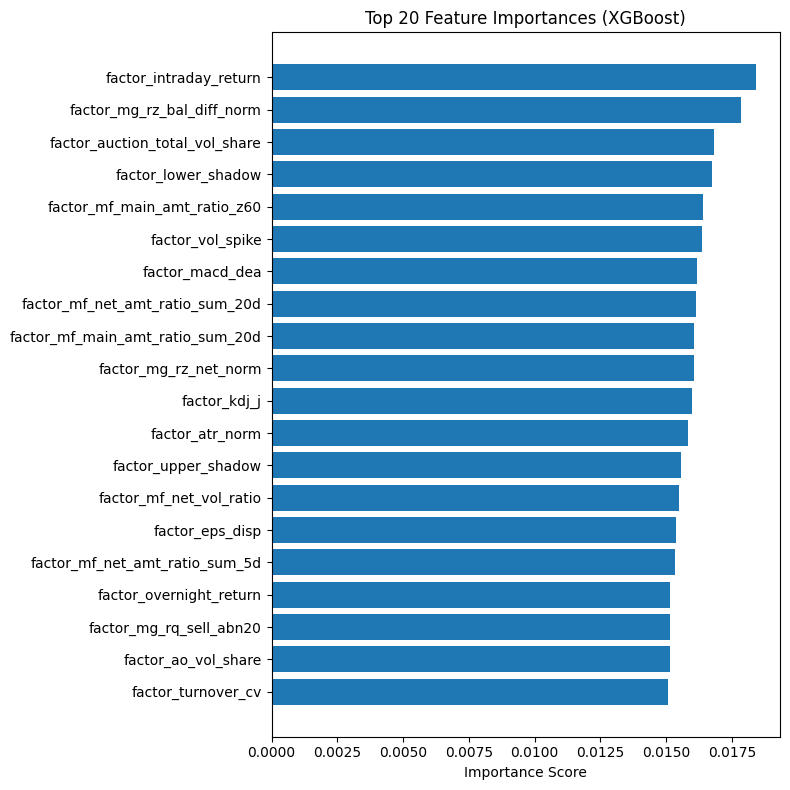

In [8]:

# Simple validation split from training period
vi = int(len(X_train)*TRAIN_TEST_SPLIT_RATIO)
X_tr, y_tr = X_train.iloc[:vi], y_train.iloc[:vi]
X_val, y_val = X_train.iloc[vi:], y_train.iloc[vi:]

model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss",
)

# Fit with early stopping when available (keeps code version-portable)
fitted = False
try:
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False); fitted=True
except TypeError:
    try:
        es = xgb.callback.EarlyStopping(rounds=50, save_best=True)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=[es], verbose=False); fitted=True
    except TypeError:
        pass
if not fitted:
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

# Show & plot importances
fi = pd.DataFrame({"Feature": factor_cols, "Importance": model.feature_importances_}) \
       .sort_values("Importance", ascending=False).reset_index(drop=True)
display(fi.head(30))

def plot_feature_importance(fi, top_n=20):
    top = fi.head(top_n)
    plt.figure(figsize=(8, max(4, top_n*0.4)))
    plt.barh(list(reversed(top["Feature"].tolist())), list(reversed(top["Importance"].tolist())))
    plt.xlabel("Importance Score"); plt.title(f"Top {top_n} Feature Importances (XGBoost)")
    plt.tight_layout(); plt.show()

plot_feature_importance(fi, top_n=20)


## 6) Build Selection‑Only Long/Short (Gross)

In [9]:

# Rank by predicted probability on test dates; long top p%, short bottom p%.
proba = model.predict_proba(X_test)[:,1]
pred = X_test.copy(); pred["prob"] = proba

close_panel = panel["Close"].unstack(level="Ticker")
test_dates = sorted(pred.index.get_level_values("Date").unique())

all_rets = []                 # daily L/S returns
baskets_by_date = {}          # store long/short baskets to compute turnover-based fees later

#REBAL = max(1, int(REBALANCE_DAYS)) --- IGNORE ---
for i in range(0, max(0, len(test_dates)-1), REBAL):
    d0 = test_dates[i]
    d1 = test_dates[min(i+REBAL, len(test_dates)-1)]
    row = pred.loc[d0]
    if isinstance(row, pd.Series): row = row.to_frame().T
    if row.shape[0] < 2: continue

    sorted_row = row.sort_values("prob", ascending=False)
    n = len(sorted_row)
    k = max(1, int(n * PORTFOLIO_PERCENTILE/100.0))
    long_tks  = sorted_row.head(k).index.tolist()
    short_tks = sorted_row.tail(k).index.tolist()
    baskets_by_date[d0] = {"long": set(long_tks), "short": set(short_tks)}

    cols = list(set(long_tks).union(set(short_tks)))
    try:
        price_slice = close_panel.loc[d0:d1, cols]
        stock_rets = price_slice.pct_change().iloc[1:]
        if stock_rets.empty: continue
        long_ret  = stock_rets[long_tks].mean(axis=1)
        short_ret = stock_rets[short_tks].mean(axis=1)
        ls = (long_ret - short_ret) / 2.0   # market‑neutral, equal gross each side
        ls.name = "LS"
        all_rets.append(ls)
    except Exception:
        continue

sel_rets = (pd.concat(all_rets).sort_index() if all_rets else pd.Series([], dtype=float))
print("Selection-only observations:", len(sel_rets))


Selection-only observations: 338


## 7) Apply Turnover‑based Fees on Rebalance Days (Selection‑Only Net)

In [10]:
def compute_selection_fees_turnover(baskets_by_date, sel_rets_index, k_per_side, fee_per_side_total):
    """
    Robust turnover and fee estimation for equal-weight L/S portfolios.
    Handles missing dates gracefully.
    """
    fee = pd.Series(0.0, index=sel_rets_index)
    prev_long, prev_short = set(), set()

    for d0 in sorted(baskets_by_date.keys()):
        current = baskets_by_date[d0]
        long_tks, short_tks = current["long"], current["short"]
        k = max(1, k_per_side)

        entries_long = len(long_tks - prev_long); exits_long = len(prev_long - long_tks)
        entries_short = len(short_tks - prev_short); exits_short = len(prev_short - short_tks)
        gross_turnover = ((entries_long + exits_long) + (entries_short + exits_short)) / k

        fee_decimal = gross_turnover * fee_per_side_total

        # find first valid trading day >= d0
        later_dates = sel_rets_index[sel_rets_index >= d0]
        if len(later_dates) > 0:
            fee.loc[later_dates[0]] += fee_decimal

        prev_long, prev_short = long_tks, short_tks

    return fee

# --- Safety checks ---
if baskets_by_date:
    first_date = sorted(baskets_by_date.keys())[0]
    k_per_side = len(baskets_by_date[first_date]["long"])
else:
    k_per_side = 1

# --- Compute fees safely ---
sel_fee_series = compute_selection_fees_turnover(
    baskets_by_date=baskets_by_date,
    sel_rets_index=sel_rets.index,
    k_per_side=k_per_side,
    fee_per_side_total=FEE_PER_SIDE_TOTAL
)

selection_only_gross = sel_rets.copy()
selection_only_net = selection_only_gross - sel_fee_series.fillna(0.0)


## 8) RSRS Timing (Quantile Thresholds)

In [11]:

# def rsrs_signal_quantile(high: pd.Series, low: pd.Series,
#                          enter_q=0.7, exit_q=0.3,
#                          window=18, zscore_window=600):
#     """
#     RSRS computes rolling OLS slope beta_t of High ~ Low over `window`,
#     then z‑scores beta_t over `zscore_window`.
#     Enter when z > enter quantile; exit when z < exit quantile.
#     """
#     df0 = pd.DataFrame({"high": high, "low": low}).dropna()
#     betas, idxs = [], []
#     for i in range(window, len(df0)+1):
#         sub = df0.iloc[i-window:i]
#         X = sm.add_constant(sub["low"].values)
#         y = sub["high"].values
#         try:
#             b = sm.OLS(y, X).fit().params[1]
#         except Exception:
#             b = np.nan
#         betas.append(b); idxs.append(sub.index[-1])
#     beta = pd.Series(betas, index=idxs).dropna()
#     z = (beta - beta.rolling(zscore_window).mean()) / beta.rolling(zscore_window).std()
#     z = z.replace([np.inf, -np.inf], np.nan).fillna(0.0)
#     enter_thr = z.quantile(enter_q)
#     exit_thr  = z.quantile(exit_q)
#     sig = pd.Series(0, index=z.index, dtype=int); state = 0
#     for dt, v in z.items():
#         if state==0 and v > enter_thr: state = 1
#         elif state==1 and v < exit_thr: state = 0
#         sig.loc[dt] = state
#     return sig, z, enter_thr, exit_thr

# # Build high/low series (fallback to benchmark ±0.5% if missing)
# if ("high" in df_m.columns) and ("low" in df_m.columns):
#     hs_high = df_m.groupby(DATE_COL)["high"].mean()
#     hs_low  = df_m.groupby(DATE_COL)["low"].mean()
# else:
#     bc = df_b["Close"]
#     hs_high = bc * (1 + 0.005)
#     hs_low  = bc * (1 - 0.005)
# hs_high.index = pd.to_datetime(hs_high.index); hs_low.index = pd.to_datetime(hs_low.index)

# rsrs_sig_full, rsrs_z, rsrs_enter_thr, rsrs_exit_thr = rsrs_signal_quantile(
#     hs_high, hs_low, enter_q=RSRS_ENTER_Q, exit_q=RSRS_EXIT_Q,
#     window=RSRS_WINDOW, zscore_window=RSRS_ZSCORE_WINDOW
# )
# # Align RSRS signal to selection dates
# rsrs_sig = rsrs_sig_full.reindex(sel_rets.index).ffill().fillna(0).astype(int)


## 9) T‑Sharpe Timing (Rolling Sharpe of Benchmark)

In [12]:

# def rolling_sharpe(ret: pd.Series, lookback=60):
#     def _sh(x):
#         x = np.asarray(x); sd = x.std(ddof=0)
#         if sd == 0: return np.nan
#         return x.mean()/sd
#     return ret.rolling(lookback).apply(_sh, raw=True)

# def tsharpe_signal(ret: pd.Series, lookback=60, enter=0.2, exit=-0.1, plot=True):
#     rs = rolling_sharpe(ret, lookback).fillna(0.0)
#     sig = pd.Series(0, index=rs.index, dtype=int); state = 0
#     for dt, v in rs.items():
#         if state==0 and v > enter: state = 1
#         elif state==1 and v < exit: state = 0
#         sig.loc[dt] = state

#     if plot:
#         plt.figure(figsize=(12,5))
#         plt.plot(rs.index, rs.values, label=f"Rolling Sharpe ({lookback}d)")
#         plt.axhline(y=enter, linestyle="--", label=f"Enter {enter}")
#         plt.axhline(y=exit, linestyle="--", label=f"Exit {exit}")
#         plt.title("Rolling Sharpe Ratio (T‑Sharpe Timing)")
#         plt.xlabel("Date"); plt.ylabel("Sharpe"); plt.legend(); plt.grid(True); plt.show()

#         summary = {"mean": float(rs.mean()), "std": float(rs.std()), "min": float(rs.min()),
#                    "25%": float(rs.quantile(0.25)), "50%": float(rs.quantile(0.5)),
#                    "75%": float(rs.quantile(0.75)), "max": float(rs.max())}
#         print("Rolling Sharpe Summary:", summary)
#     return sig, rs

# tsh_sig_full, tsh_rs = tsharpe_signal(bm_daily_ret, TSHARPE_LOOKBACK, TSHARPE_ENTER, TSHARPE_EXIT, plot=True)
# tsh_sig = tsh_sig_full.reindex(sel_rets.index).ffill().fillna(0).astype(int)


## 10) Timing Combinations & Timing‑only Fees

In [13]:

# # Gross returns with timing overlays
# sel_rsrs_gross = sel_rets * rsrs_sig
# sel_tsh_gross  = sel_rets * tsh_sig

# combo_sig = ((rsrs_sig==1) | (tsh_sig==1)).astype(int)  # OR logic (change to & for AND)
# sel_or_gross = sel_rets * combo_sig

# # Timing‑only fees: charge costs when timing changes state (0↔1)
# fee_per_flip = 2.0 * (FEE_PER_SIDE + SLIPPAGE_PER_SIDE)
# rsrs_flip = rsrs_sig.diff().abs().fillna(0.0)
# tsh_flip  = tsh_sig.diff().abs().fillna(0.0)
# or_flip   = combo_sig.diff().abs().fillna(0.0)

# sel_rsrs_net = sel_rsrs_gross - rsrs_flip * fee_per_flip
# sel_tsh_net  = sel_tsh_gross  - tsh_flip  * fee_per_flip
# sel_or_net   = sel_or_gross   - or_flip   * fee_per_flip


## 11) Partial Timing (Halve on Exit, Restore on Enter)

In [14]:

# # Rule:
# # - First enter (0→1): exposure = 100%
# # - Exit (1→0): exposure *= 0.5
# # - Re‑enter (0→1 again): exposure = 100%

# exposure = 0.0; exposures, rets_partial = [], []
# for dt, sig in combo_sig.items():
#     if exposure == 0 and sig == 1:
#         exposure = 1.0
#     elif exposure > 0 and sig == 0:
#         exposure = exposure * 0.7
#     elif exposure < 1.0 and sig == 1:
#         exposure = 1.0
#     exposures.append(exposure)
#     rets_partial.append(sel_rets.loc[dt] * exposure)

# exposure_series = pd.Series(exposures, index=combo_sig.index, name="Exposure")
# sel_with_partial_timing = pd.Series(rets_partial, index=combo_sig.index, name="PartialTiming")

# # Timing‑only cost proportional to exposure change (Δexposure)
# delta_exp = exposure_series.diff().abs().fillna(0.0)
# sel_with_partial_timing_net = sel_with_partial_timing - delta_exp * 2.0 * (FEE_PER_SIDE + SLIPPAGE_PER_SIDE)


## 12) Plot Equity Curves (Gross & Net)

In [15]:

# def plot_equity(series_dict, title="Equity Curves"):
#     fig, ax = plt.subplots(figsize=(12,7))
    
#     # Predefined colors by strategy group
#     color_map = {
#         "Selection": "tab:blue",
#         "RSRS": "tab:green",
#         "T-Sharpe": "tab:red",
#         "OR": "tab:purple",
#         "Partial": "tab:orange",
#         "Benchmark": "black"
#     }
    
#     # Plot with style (gross=solid, net=dashed)
#     for name, rets in series_dict.items():
#         if rets is None or len(rets)==0: 
#             continue
#         eq = (1+rets).cumprod()*STARTING_CAPITAL
        
#         # choose color by keyword
#         c = None
#         for key in color_map:
#             if key in name:
#                 c = color_map[key]
#                 break
#         if c is None:
#             c = "gray"
        
#         # solid line for gross, dashed for net
#         style = "-" if "(gross)" in name else "--" if "(net)" in name else "-"
        
#         ax.plot(eq.index, eq.values, label=name, color=c, linestyle=style, linewidth=1.8)
    
#     ax.set_title(title)
#     ax.set_xlabel("Date")
#     ax.set_ylabel("Portfolio Value")
#     ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: f"${x:,.0f}"))
#     ax.legend(loc="upper left", bbox_to_anchor=(1,1))  # place legend outside plot
#     ax.grid(True)
#     plt.tight_layout()
#     plt.show()

# bm_aligned = bm_daily_ret.reindex(sel_rets.index).fillna(0.0)

# plot_equity({
#     "Selection only (gross)": selection_only_gross,
#     "Selection only (net)": selection_only_net,
#     "RSRS timing (gross)": sel_rsrs_gross,
#     "RSRS timing (net)": sel_rsrs_net,
#     "T-Sharpe timing (gross)": sel_tsh_gross,
#     "T-Sharpe timing (net)": sel_tsh_net,
#     "OR timing (gross)": sel_or_gross,
#     "OR timing (net)": sel_or_net,
#     #"Partial timing (gross)": sel_with_partial_timing,
#     "Partial timing (net)": sel_with_partial_timing_net,
#     "SP500 Benchmark": bm_aligned
# }, title="Equity Curves — Selection & Timing (Gross/Net)")



## 13) Performance Table

In [17]:

# perf_df = pd.DataFrame({
#     "selection_only_gross": selection_only_gross,
#     "selection_only_net": selection_only_net,
#     "rsrs_gross": sel_rsrs_gross,
#     "rsrs_net": sel_rsrs_net,
#     "tsharpe_gross": sel_tsh_gross,
#     "tsharpe_net": sel_tsh_net,
#     "or_gross": sel_or_gross,
#     "or_net": sel_or_net,
#     "partial_gross": sel_with_partial_timing,
#     "partial_net": sel_with_partial_timing_net,
#     "benchmark": bm_aligned
# }).dropna(how="all")

# if Strategy_performance is not None:
#     Strategy_performance(perf_df, mark_benchmark="benchmark", periods="daily")
# else:
#     display(perf_df.tail())


In [18]:
def summarize_strategies(returns_dict, risk_free_rate=0.0, periods_per_year=252):
    """
    Summarize performance metrics for multiple return series.
    
    Parameters
    ----------
    returns_dict : dict of {name: pd.Series}
        Each value should be a daily return series.
    risk_free_rate : float
        Daily risk-free rate (default 0).
    periods_per_year : int
        Number of trading periods per year (default 252).
    
    Returns
    -------
    summary : pd.DataFrame
        Table with Annual Return, Volatility, Sharpe, Max Drawdown.
    """
    rows = []
    for name, rets in returns_dict.items():
        if rets is None or len(rets)==0:
            continue
        rets = rets.dropna()
        if len(rets)==0: continue
        
        # cumulative growth
        cum = (1+rets).cumprod()
        
        # metrics
        ann_ret = (cum.iloc[-1]**(periods_per_year/len(rets)) - 1) * 100
        vol = rets.std() * np.sqrt(periods_per_year) * 100
        sharpe = (ann_ret - risk_free_rate) / vol if vol>0 else np.nan
        running_max = cum.cummax()
        dd = (cum/running_max - 1).min() *100
        
        rows.append({
            "Strategy": name,
            "Annual Return %": ann_ret,
            "Volatility %": vol,
            "Sharpe": sharpe,
            "Max Drawdown %": dd
        })
    
    return pd.DataFrame(rows).set_index("Strategy").sort_values("Sharpe", ascending=False)

# ---- Call the function on all strategies ----
summary = summarize_strategies({
    "Selection Gross": selection_only_gross,
    "Selection Net": selection_only_net,
    "RSRS Gross": sel_rsrs_gross,
    "RSRS Net": sel_rsrs_net,
    "TSharpe Gross": sel_tsh_gross,
    "TSharpe Net": sel_tsh_net,
    "OR Gross": sel_or_gross,
    "OR Net": sel_or_net,
    "Partial Gross": sel_with_partial_timing,
    "Partial Net": sel_with_partial_timing_net,
    "Benchmark": bm_aligned
})

# Pretty print
pd.options.display.float_format = "{:.2%}".format
display(summary)


NameError: name 'sel_rsrs_gross' is not defined

## 14) Macro-adjusted strategy

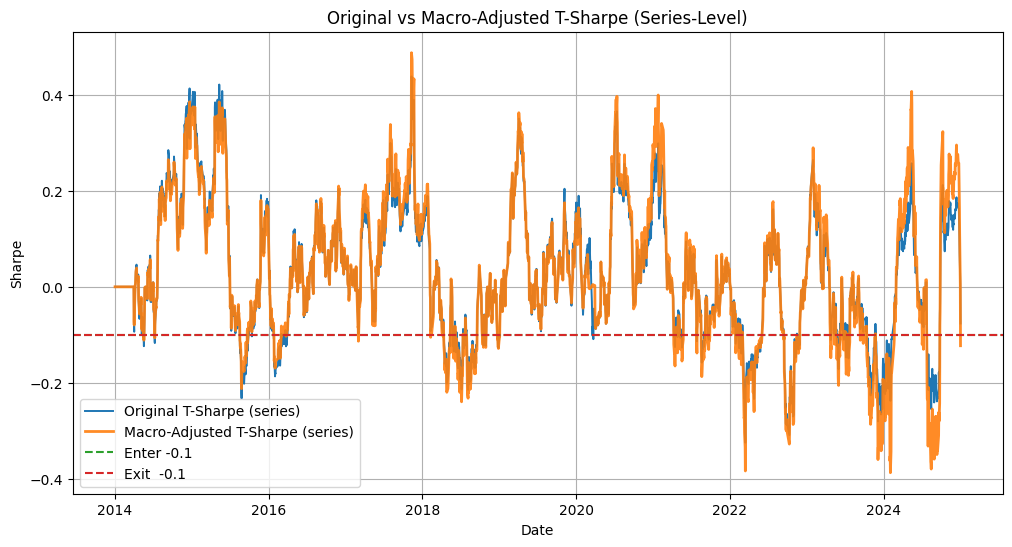

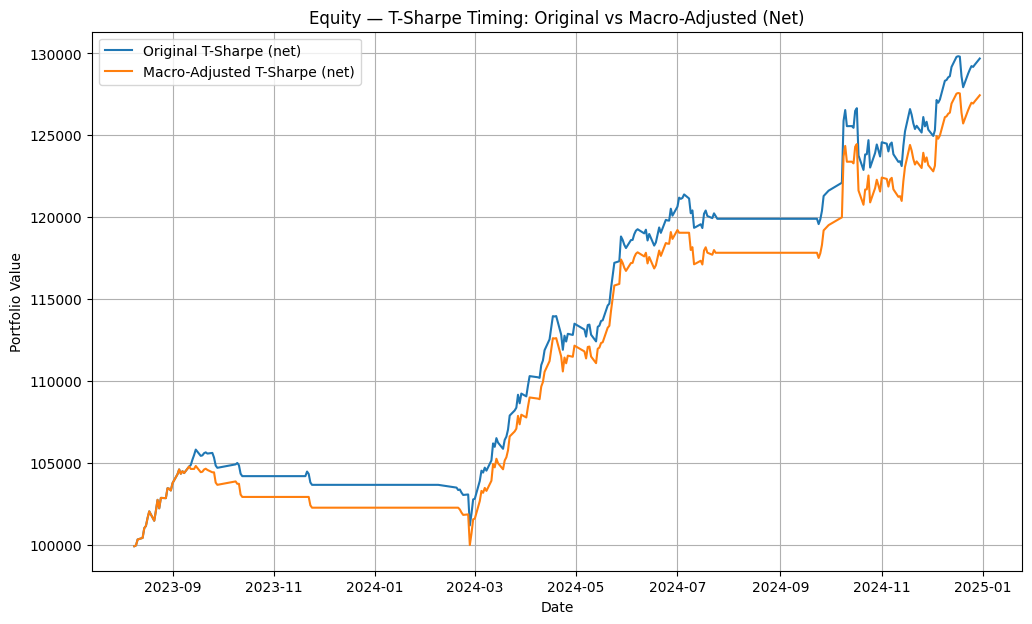

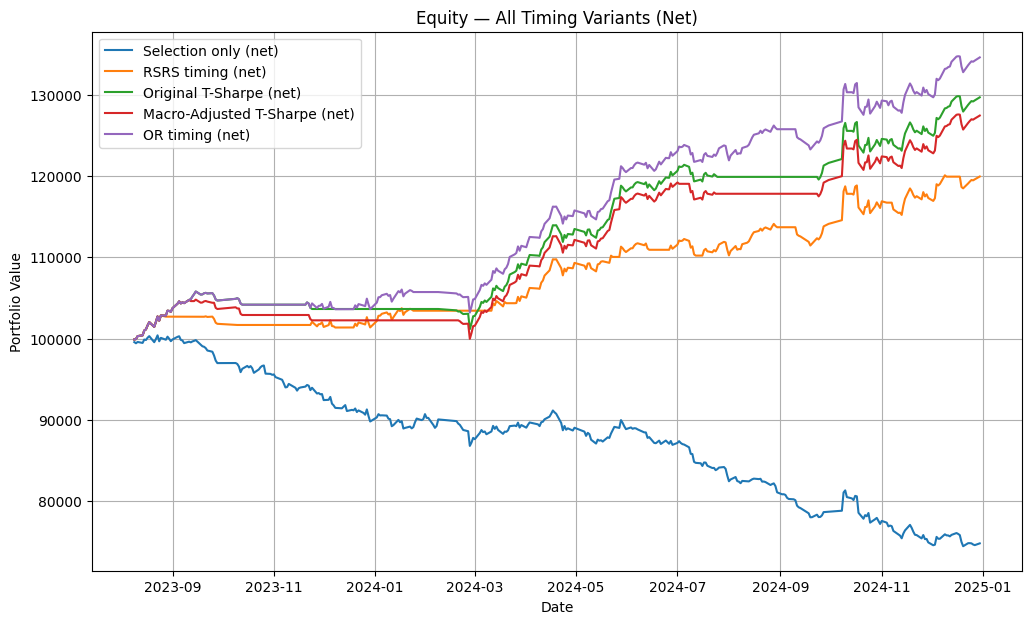

In [ ]:
# # === New Cell: Macro-Adjusted T-Sharpe using PMI, CPI, and M1 (no overwrite) ===
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from pathlib import Path

# # ------------------------------------------------------------
# # 0) Robust path handling for your macro file
# #    (tries your Windows paths first, then /mnt/data fallback)
# # ------------------------------------------------------------
# macro_candidates = [
#     Path("F:/Code_Crunch/test/macroeconomics_CN.xlsx"),
# ]
# macro_path = next((p for p in macro_candidates if p.exists()), None)
# if macro_path is None:
#     raise FileNotFoundError("Could not find 'macroeconomics_CN.xlsx' in any known location.")

# # ------------------------------------------------------------
# # 1) Load monthly macro data and coerce to numeric
# # ------------------------------------------------------------
# macro_m = pd.read_excel(macro_path, index_col=0)
# macro_m.index = pd.to_datetime(macro_m.index, errors="coerce")
# macro_m = macro_m[macro_m.index.notna()]

# # Coerce all to numeric (handles %, commas)
# for c in macro_m.columns:
#     macro_m[c] = pd.to_numeric(
#         macro_m[c].astype(str).str.replace("%","").str.replace(",",""),
#         errors="coerce"
#     )

# # Keep only expected columns
# expected_cols = ["PMI", "CPI", "M1"]
# missing = [c for c in expected_cols if c not in macro_m.columns]
# if missing:
#     raise KeyError(f"Missing required macro columns in {macro_path.name}: {missing}. "
#                    f"Found columns: {list(macro_m.columns)}")

# macro_m = macro_m[expected_cols].copy()

# # ------------------------------------------------------------
# # 2) Z-score standardization (monthly)
# # ------------------------------------------------------------
# macro_std_m = (macro_m - macro_m.mean()) / macro_m.std()

# # Composite macro score:
# #   + M1 (liquidity)    -> boost exposure
# #   + PMI (momentum)    -> boost exposure
# #   - CPI (inflation)   -> reduce exposure
# macro_std_m["macro_score"] = (
#     0.4 * macro_std_m["M1"]
#   - 0.3 * macro_std_m["CPI"]
#   + 0.3 * macro_std_m["PMI"]
# )

# # ------------------------------------------------------------
# # 3) Align monthly → daily → T-Sharpe index
# #     Your notebook defines: tsh_rs (rolling Sharpe series)
# # ------------------------------------------------------------
# if 'tsh_rs' not in globals():
#     raise RuntimeError("Expected 'tsh_rs' (rolling Sharpe series) not found. "
#                        "Run the T-Sharpe cell first to create tsh_rs.")

# # Resample monthly to daily by forward-fill, then align to tsh_rs index
# macro_daily = macro_std_m.resample("D").ffill()
# macro_on_tsh = macro_daily.reindex(tsh_rs.index).ffill()
# macro_on_tsh["macro_score"] = macro_on_tsh["macro_score"].fillna(0.0)

# # ------------------------------------------------------------
# # 4) Build macro-adjusted T-Sharpe series and timing signal
# #     Use your existing thresholds: TSHARPE_ENTER / TSHARPE_EXIT
# # ------------------------------------------------------------
# alpha = 0.5  # sensitivity factor; tune 0.3–0.8 if you like
# tsh_rs_adj = tsh_rs * (1 + alpha * macro_on_tsh["macro_score"])

# def tsharpe_signal_from_series(rs_series: pd.Series, enter: float, exit: float) -> pd.Series:
#     """State machine on a precomputed Sharpe series to get a 0/1 timing signal."""
#     sig = pd.Series(0, index=rs_series.index, dtype=int)
#     state = 0
#     for dt, v in rs_series.items():
#         if state == 0 and v > enter:
#             state = 1
#         elif state == 1 and v < exit:
#             state = 0
#         sig.loc[dt] = state
#     return sig

# # Use your configured thresholds
# tsh_sig_adj_full = tsharpe_signal_from_series(
#     tsh_rs_adj, enter=TSHARPE_ENTER, exit=TSHARPE_EXIT
# )

# # Align adjusted timing to selection return index
# tsh_sig_adj = tsh_sig_adj_full.reindex(sel_rets.index).ffill().fillna(0).astype(int)

# # ------------------------------------------------------------
# # 5) Plots: original vs adjusted T-Sharpe series
# # ------------------------------------------------------------
# plt.figure(figsize=(12,6))
# plt.plot(tsh_rs.index, tsh_rs.values,  label="Original T-Sharpe (series)", linewidth=1.4)
# plt.plot(tsh_rs_adj.index, tsh_rs_adj.values, label="Macro-Adjusted T-Sharpe (series)", linewidth=2.0, alpha=0.9)
# plt.axhline(TSHARPE_ENTER, linestyle="--", color="tab:green",  label=f"Enter {TSHARPE_ENTER}")
# plt.axhline(TSHARPE_EXIT,  linestyle="--", color="tab:red",    label=f"Exit  {TSHARPE_EXIT}")
# plt.title("Original vs Macro-Adjusted T-Sharpe (Series-Level)")
# plt.xlabel("Date"); plt.ylabel("Sharpe"); plt.grid(True); plt.legend()
# plt.show()

# # ------------------------------------------------------------
# # 6) Strategy returns using adjusted timing (gross & net)
# #     Mirrors your existing timing-cost model:
# #       sel_tsh_gross  = sel_rets * tsh_sig
# #       sel_tsh_net    = sel_tsh_gross - (flips * fee_per_flip)
# # ------------------------------------------------------------
# # Gross (adjusted)
# sel_tsh_gross_adj = sel_rets * tsh_sig_adj

# # Timing flip costs (use your existing fee model)
# fee_per_flip = 2.0 * (FEE_PER_SIDE + SLIPPAGE_PER_SIDE)
# tsh_flip_adj = tsh_sig_adj.diff().abs().fillna(0.0)

# sel_tsh_net_adj = sel_tsh_gross_adj - tsh_flip_adj * fee_per_flip

# # ------------------------------------------------------------
# # 7) Equity curve comparison (original vs adjusted)
# #     We DO NOT overwrite your existing variables (sel_tsh_gross, sel_tsh_net, etc.)
# # ------------------------------------------------------------
# def plot_equity_curves(series_dict, title):
#     fig, ax = plt.subplots(figsize=(12,7))
#     for name, rets in series_dict.items():
#         if rets is None or len(rets) == 0:
#             continue
#         eq = (1 + rets).cumprod() * STARTING_CAPITAL
#         ax.plot(eq.index, eq.values, label=name)
#     ax.set_title(title)
#     ax.set_xlabel("Date"); ax.set_ylabel("Portfolio Value")
#     ax.legend(); ax.grid(True)
#     plt.show()

# plot_equity_curves({
#     "Original T-Sharpe (net)": sel_tsh_net,
#     "Macro-Adjusted T-Sharpe (net)": sel_tsh_net_adj,
# }, title="Equity — T-Sharpe Timing: Original vs Macro-Adjusted (Net)")

# # (Optional) If you want to include selection-only and OR strategies for context:
# plot_equity_curves({
#     "Selection only (net)": selection_only_net,
#     "RSRS timing (net)": sel_rsrs_net,
#     "Original T-Sharpe (net)": sel_tsh_net,
#     "Macro-Adjusted T-Sharpe (net)": sel_tsh_net_adj,
#     "OR timing (net)": sel_or_net,
# }, title="Equity — All Timing Variants (Net)")


In [ ]:
# # ---- Call the function on all strategies ----
# summary = summarize_strategies({
#     "Selection Net": selection_only_net,
#     "Macro-Adjusted T-Sharpe (net)": sel_tsh_net_adj,
#     "RSRS Net": sel_rsrs_net,
#     "TSharpe Net": sel_tsh_net,
#     "OR Net": sel_or_net,
#     "Partial Net": sel_with_partial_timing_net,
#     "Benchmark": bm_aligned
# })

# # Pretty print
# pd.options.display.float_format = "{:.2%}".format
# display(summary)

,Annual Return %,Volatility %,Sharpe,Max Drawdown %
Strategy,,,,
Partial Net,2674.34%,747.07%,357.98%,-297.76%
OR Net,2479.80%,745.85%,332.48%,-297.76%
TSharpe Net,2138.87%,684.25%,312.59%,-438.11%
Macro-Adjusted T-Sharpe (net),1981.88%,684.77%,289.42%,-460.93%
RSRS Net,1452.34%,679.55%,213.72%,-304.93%
Benchmark,36.18%,1940.11%,1.86%,-2053.64%
Selection Net,-1944.85%,782.52%,-248.54%,-2583.49%


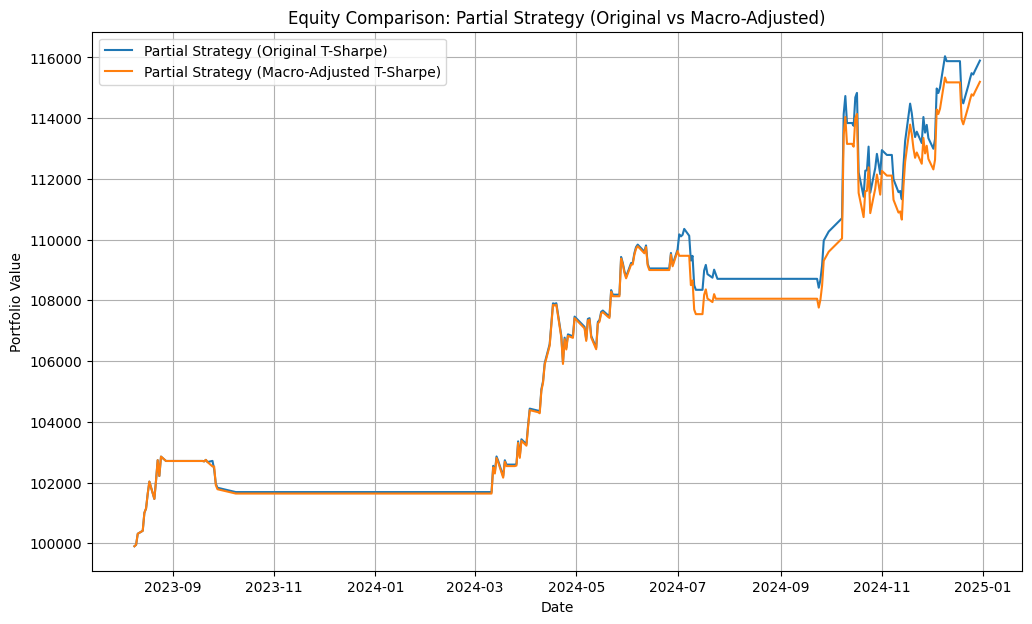

Performance summary (net returns):
Original Partial: {'Ann.Return': '11.63%', 'Volatility': '6.10%', 'Sharpe': '1.91'}
Macro-Adjusted Partial: {'Ann.Return': '11.12%', 'Volatility': '6.11%', 'Sharpe': '1.82'}


In [ ]:
# # === New Cell: Compare Original vs Macro-Adjusted T-Sharpe Partial Strategy ===
# import matplotlib.pyplot as plt

# # 1) Build partial strategies (combine selection + RSRS + T-Sharpe)
# #    Your existing partial strategy likely multiplies all timing signals.
# #    For safety we reconstruct both explicitly here.

# # Original T-Sharpe partial (as in previous notebook logic)
# partial_sig_orig = (tsh_sig & rsrs_sig).astype(int)  # logical AND of RSRS & T-Sharpe
# partial_gross_orig = sel_rets * partial_sig_orig
# partial_net_orig   = partial_gross_orig - partial_sig_orig.diff().abs().fillna(0) * 2.0 * (FEE_PER_SIDE + SLIPPAGE_PER_SIDE)

# # Macro-adjusted T-Sharpe partial strategy
# partial_sig_adj = (tsh_sig_adj & rsrs_sig).astype(int)
# partial_gross_adj = sel_rets * partial_sig_adj
# partial_net_adj   = partial_gross_adj - partial_sig_adj.diff().abs().fillna(0) * 2.0 * (FEE_PER_SIDE + SLIPPAGE_PER_SIDE)

# # 2) Plot comparison of equity curves
# def plot_equity(series_dict, title="Equity Comparison: Partial Strategy (Original vs Macro-Adjusted)"):
#     fig, ax = plt.subplots(figsize=(12,7))
#     for name, rets in series_dict.items():
#         if rets is None or len(rets)==0: 
#             continue
#         eq = (1 + rets).cumprod() * STARTING_CAPITAL
#         ax.plot(eq.index, eq.values, label=name)
#     ax.set_title(title)
#     ax.set_xlabel("Date"); ax.set_ylabel("Portfolio Value")
#     ax.legend(); ax.grid(True)
#     plt.show()

# plot_equity({
#     "Partial Strategy (Original T-Sharpe)": partial_net_orig,
#     "Partial Strategy (Macro-Adjusted T-Sharpe)": partial_net_adj,
# })

# # 3) Optional: quick performance summary
# def summary_stats(series):
#     ann_return = (1 + series).prod() ** (252 / len(series)) - 1
#     vol = series.std() * (252 ** 0.5)
#     sharpe = ann_return / vol if vol != 0 else 0
#     return {"Ann.Return": f"{ann_return:.2%}", "Volatility": f"{vol:.2%}", "Sharpe": f"{sharpe:.2f}"}

# print("Performance summary (net returns):")
# print("Original Partial:", summary_stats(partial_net_orig))
# print("Macro-Adjusted Partial:", summary_stats(partial_net_adj))


In [ ]:
# # 1) Is T-Sharpe truly always on after your threshold change?
# print("tsh_sig values:", tsh_sig.value_counts(dropna=False).to_dict())
# print("Number of flips (tsh):", int(tsh_sig.diff().abs().fillna(0).sum()))

# # 2) Are you accidentally plotting OR/Partial instead of pure T-Sharpe selection?
# print("OR sig flips:", int(((rsrs_sig==1) | (tsh_sig==1)).astype(int).diff().abs().fillna(0).sum()))

# # 3) Fees actually charged
# print("Selection turnover fee total:", float(sel_fee_series.fillna(0).sum()))
# fee_per_flip = 2.0 * (FEE_PER_SIDE + SLIPPAGE_PER_SIDE)
# print("Timing flip fee total (tsh):", float((tsh_sig.diff().abs().fillna(0) * fee_per_flip).sum()))


# # 4) Exposure stats for Partial if used
# try:
#     print("Partial exposure stats:", exposure.describe())
# except Exception:
#     pass

# # 5) Fairness check: compare benchmark vs “benchmark masked by T-Sharpe”
# aligned_index = sel_rets.index.union(bm_daily_ret.index)
# bm_aligned = bm_daily_ret.reindex(aligned_index).fillna(0)
# tsh_aligned = tsh_sig.reindex(aligned_index).ffill().fillna(1)
# bm_masked_by_tsh = bm_aligned * tsh_aligned


# #bm_masked_by_tsh = bm_daily_ret.reindex(tsh_sig.index).fillna(0) * tsh_sig
# bm_eq = (1 + bm_daily_ret).cumprod()
# bm_masked_eq = (1 + bm_masked_by_tsh).cumprod()
# print("Benchmark final multiple:", float(bm_eq.iloc[-1]))
# print("Benchmark masked by T-Sharpe final multiple:", float(bm_masked_eq.iloc[-1]))


tsh_sig values: {1: 215, 0: 123}
Number of flips (tsh): 8
OR sig flips: 12
Selection turnover fee total: 0.6800499999999999
Timing flip fee total (tsh): 0.0112
Benchmark final multiple: 1.6946374599586997
Benchmark masked by T-Sharpe final multiple: 1.9960108733888575


In [ ]:
# print("bm_daily_ret index length:", len(bm_daily_ret))
# print("tsh_sig index length:", len(tsh_sig))
# print("Overlap length:", len(bm_daily_ret.index.intersection(tsh_sig.index)))
# print("Overlap ratio:", len(bm_daily_ret.index.intersection(tsh_sig.index)) / len(bm_daily_ret))


bm_daily_ret index length: 2676
tsh_sig index length: 338
Overlap length: 338
Overlap ratio: 0.12630792227204785


## 15) Change rebalance date

In [ ]:

# # === Utility: quick rebalance reruns ===
# def run_strategy_with_rebalance(rebalance_days, *, verbose=True, plot_curves=False):
#     """Recompute selection, timing, and summary metrics for a custom rebalance cadence."""
#     from IPython.display import display

#     rebalance_days = int(rebalance_days)
#     if rebalance_days < 1:
#         raise ValueError("rebalance_days must be >= 1")
#     REBAL = max(1, rebalance_days)

#     required_globals = ["panel", "factor_cols", "bm_daily_ret", "df_m", "df_b"]
#     missing = [name for name in required_globals if name not in globals()]
#     if missing:
#         raise RuntimeError(f"Missing required variables: {missing}. Run the data preparation cells first.")

#     df2 = panel.copy()
#     df2["Future_Return"] = df2.groupby(level="Ticker")["Close"].shift(-REBAL) / df2["Close"] - 1
#     median_cs = df2.groupby(level="Date")["Future_Return"].transform("median")
#     df2["Target"] = (df2["Future_Return"] > median_cs).astype(int)

#     clean = df2.dropna(subset=factor_cols + ["Target", "Close"])
#     unique_dates = pd.Index(sorted(clean.index.get_level_values("Date").unique()))
#     if len(unique_dates) < 2:
#         raise RuntimeError("Not enough dates to build a train/test split for this rebalance cadence.")

#     split_idx = max(1, min(int(len(unique_dates) * TRAIN_TEST_SPLIT_RATIO), len(unique_dates) - 1))
#     split_date = unique_dates[split_idx]

#     train = clean[clean.index.get_level_values("Date") < split_date]
#     test = clean[clean.index.get_level_values("Date") >= split_date]
#     if train.empty or test.empty:
#         raise RuntimeError("Train/Test split produced empty sets. Adjust TRAIN_TEST_SPLIT_RATIO or check data.")

#     X_train, y_train = train[factor_cols], train["Target"]
#     X_test = test[factor_cols]
#     if X_test.empty:
#         raise RuntimeError("No test observations available after applying the rebalance cadence.")

#     vi = max(1, min(int(len(X_train) * 0.85), len(X_train) - 1))
#     X_tr, y_tr = X_train.iloc[:vi], y_train.iloc[:vi]
#     X_val, y_val = X_train.iloc[vi:], y_train.iloc[vi:]
#     if X_val.empty:
#         X_tr, y_tr = X_train, y_train
#         X_val, y_val = X_train, y_train

#     model = xgb.XGBClassifier(
#         objective="binary:logistic",
#         n_estimators=1000,
#         learning_rate=0.05,
#         max_depth=4,
#         random_state=42,
#         n_jobs=-1,
#         eval_metric="logloss",
#     )

#     fitted = False
#     try:
#         model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False)
#         fitted = True
#     except TypeError:
#         try:
#             es = xgb.callback.EarlyStopping(rounds=50, save_best=True)
#             model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=[es], verbose=False)
#             fitted = True
#         except TypeError:
#             pass
#     if not fitted:
#         model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

#     proba = model.predict_proba(X_test)[:, 1]
#     pred = X_test.copy()
#     pred["prob"] = proba

#     close_panel = panel["Close"].unstack(level="Ticker")
#     test_dates = sorted(pred.index.get_level_values("Date").unique())

#     all_rets = []
#     baskets_by_date = {}
#     for i in range(0, max(0, len(test_dates) - 1), REBAL):
#         d0 = test_dates[i]
#         d1 = test_dates[min(i + REBAL, len(test_dates) - 1)]
#         row = pred.loc[d0]
#         if isinstance(row, pd.Series):
#             row = row.to_frame().T
#         if row.shape[0] < 2:
#             continue

#         sorted_row = row.sort_values("prob", ascending=False)
#         n = len(sorted_row)
#         k = max(1, int(n * PORTFOLIO_PERCENTILE / 100.0))
#         long_tks = sorted_row.head(k).index.tolist()
#         short_tks = sorted_row.tail(k).index.tolist()
#         baskets_by_date[d0] = {"long": set(long_tks), "short": set(short_tks)}

#         cols = list(set(long_tks).union(set(short_tks)))
#         try:
#             price_slice = close_panel.loc[d0:d1, cols]
#             stock_rets = price_slice.pct_change().iloc[1:]
#             if stock_rets.empty:
#                 continue
#             long_ret = stock_rets[long_tks].mean(axis=1)
#             short_ret = stock_rets[short_tks].mean(axis=1)
#             ls = (long_ret - short_ret) / 2.0
#             ls.name = "LS"
#             all_rets.append(ls)
#         except Exception:
#             continue

#     sel_rets = pd.concat(all_rets).sort_index() if all_rets else pd.Series(dtype=float)
#     if sel_rets.empty:
#         raise RuntimeError("Selection returns are empty. Check coverage for the requested rebalance cadence.")

#     if baskets_by_date:
#         any_date = next(iter(baskets_by_date))
#         k_per_side = max(1, len(baskets_by_date[any_date]["long"]))
#     else:
#         k_per_side = 1

#     sel_fee_series = compute_selection_fees_turnover(
#         baskets_by_date=baskets_by_date,
#         sel_rets_index=sel_rets.index,
#         k_per_side=k_per_side,
#         fee_per_side_total=FEE_PER_SIDE_TOTAL,
#     )

#     selection_only_gross = sel_rets.copy()
#     selection_only_net = selection_only_gross - sel_fee_series.reindex(sel_rets.index).fillna(0.0)

#     if ("high" in df_m.columns) and ("low" in df_m.columns):
#         hs_high = df_m.groupby(DATE_COL)["high"].mean()
#         hs_low = df_m.groupby(DATE_COL)["low"].mean()
#     else:
#         bc = df_b["Close"]
#         hs_high = bc * (1 + 0.005)
#         hs_low = bc * (1 - 0.005)
#     hs_high.index = pd.to_datetime(hs_high.index)
#     hs_low.index = pd.to_datetime(hs_low.index)

#     rsrs_sig_full, _, _, _ = rsrs_signal_quantile(
#         hs_high,
#         hs_low,
#         enter_q=RSRS_ENTER_Q,
#         exit_q=RSRS_EXIT_Q,
#         window=RSRS_WINDOW,
#         zscore_window=RSRS_ZSCORE_WINDOW,
#     )

#     base_index = selection_only_gross.index
#     rsrs_sig = rsrs_sig_full.reindex(base_index).ffill().fillna(0).astype(int)

#     tsh_sig_full, _ = tsharpe_signal(
#         bm_daily_ret,
#         TSHARPE_LOOKBACK,
#         TSHARPE_ENTER,
#         TSHARPE_EXIT,
#         plot=False,
#     )
#     tsh_sig = tsh_sig_full.reindex(base_index).ffill().fillna(0).astype(int)

#     sel_rsrs_gross = selection_only_gross * rsrs_sig
#     sel_tsh_gross = selection_only_gross * tsh_sig

#     combo_sig = ((rsrs_sig == 1) | (tsh_sig == 1)).astype(int)
#     sel_or_gross = selection_only_gross * combo_sig

#     fee_per_flip = 2.0 * (FEE_PER_SIDE + SLIPPAGE_PER_SIDE)
#     rsrs_flip = rsrs_sig.diff().abs().fillna(0.0)
#     tsh_flip = tsh_sig.diff().abs().fillna(0.0)
#     or_flip = combo_sig.diff().abs().fillna(0.0)

#     sel_rsrs_net = sel_rsrs_gross - rsrs_flip * fee_per_flip
#     sel_tsh_net = sel_tsh_gross - tsh_flip * fee_per_flip
#     sel_or_net = sel_or_gross - or_flip * fee_per_flip

#     exposure = 0.0
#     exposures = []
#     rets_partial = []
#     aligned_sel = selection_only_gross.reindex(base_index).fillna(0.0)
#     for dt, sig in combo_sig.items():
#         if exposure == 0 and sig == 1:
#             exposure = 1.0
#         elif exposure > 0 and sig == 0:
#             exposure = exposure * 0.7
#         elif exposure < 1.0 and sig == 1:
#             exposure = 1.0
#         exposures.append(exposure)
#         rets_partial.append(aligned_sel.loc[dt] * exposure)

#     exposure_series = pd.Series(exposures, index=combo_sig.index, name="Exposure")
#     sel_with_partial_timing = pd.Series(rets_partial, index=combo_sig.index, name="PartialTiming")
#     delta_exp = exposure_series.diff().abs().fillna(0.0)
#     sel_with_partial_timing_net = sel_with_partial_timing - delta_exp * fee_per_flip

#     bm_aligned = bm_daily_ret.reindex(base_index).fillna(0.0)

#     results = {
#         "Selection Gross": selection_only_gross,
#         "Selection Net": selection_only_net,
#         "RSRS Gross": sel_rsrs_gross,
#         "RSRS Net": sel_rsrs_net,
#         "TSharpe Gross": sel_tsh_gross,
#         "TSharpe Net": sel_tsh_net,
#         "OR Gross": sel_or_gross,
#         "OR Net": sel_or_net,
#         "Partial Gross": sel_with_partial_timing,
#         "Partial Net": sel_with_partial_timing_net,
#         "Benchmark": bm_aligned,
#     }

#     summary = summarize_strategies(results)
#     summary.attrs["rebalance_days"] = REBAL

#     if verbose:
#         print(f"Rebalance days: {REBAL}")
#         display(summary)

#     if plot_curves:
#         plot_equity(
#             {
#                 "Selection only (gross)": selection_only_gross,
#                 "Selection only (net)": selection_only_net,
#                 "RSRS timing (gross)": sel_rsrs_gross,
#                 "RSRS timing (net)": sel_rsrs_net,
#                 "T-Sharpe timing (gross)": sel_tsh_gross,
#                 "T-Sharpe timing (net)": sel_tsh_net,
#                 "OR timing (gross)": sel_or_gross,
#                 "OR timing (net)": sel_or_net,
#                 "Partial timing (gross)": sel_with_partial_timing,
#                 "Partial timing (net)": sel_with_partial_timing_net,
#                 "HS300 Benchmark": bm_aligned,
#             },
#             title=f"Equity Curves - Rebalance every {REBAL} day(s)",
#         )

#     return summary, results


# def compare_rebalance_settings(rebalance_days_list, focus_strategy="Partial Net", plot_each=False):
#     """Run multiple quick rebalance backtests and aggregate their summaries."""
#     from IPython.display import display

#     summaries_long = []
#     focus_rows = []
#     detail = {}

#     for rb in rebalance_days_list:
#         summary, series_dict = run_strategy_with_rebalance(rb, verbose=False, plot_curves=plot_each)
#         detail[rb] = {"summary": summary, "series": series_dict}

#         summary_reset = summary.reset_index().rename(columns={"index": "Strategy"})
#         summary_reset["Rebalance Days"] = rb
#         summaries_long.append(summary_reset)

#         if focus_strategy in summary.index:
#             focus_row = summary.loc[focus_strategy].to_dict()
#             focus_row["Strategy"] = focus_strategy
#             focus_row["Rebalance Days"] = rb
#             focus_rows.append(focus_row)

#     combined = pd.concat(summaries_long, ignore_index=True) if summaries_long else pd.DataFrame()
#     focus_df = pd.DataFrame(focus_rows)
#     if not focus_df.empty:
#         focus_df = focus_df.set_index("Rebalance Days")

#     if not combined.empty:
#         print("Combined summary across strategies:")
#         display(combined)
#     if not focus_df.empty:
#         print(f"Focus on '{focus_strategy}' by rebalance cadence:")
#         display(focus_df)

#     return combined, focus_df, detail


In [ ]:

# # Example: adjust the list to compare alternative rebalance cadences
# rebalance_options = [1, 5, 22]
# combined_summary, partial_focus, rebalance_outputs = compare_rebalance_settings(
#     rebalance_options,
#     focus_strategy="Partial Net",
#     plot_each=False,
# )

Combined summary across strategies:


,Strategy,Annual Return %,Volatility %,Sharpe,Max Drawdown %,Rebalance Days
0,Selection Gross,4572.20%,840.59%,543.93%,-304.65%,1
1,Partial Gross,3922.14%,803.91%,487.88%,-304.65%,1
2,TSharpe Gross,3465.90%,734.12%,472.12%,-304.65%,1
3,OR Gross,3778.60%,800.95%,471.77%,-370.63%,1
4,Partial Net,3793.52%,805.44%,470.99%,-304.65%,1
5,TSharpe Net,3353.81%,736.60%,455.31%,-304.65%,1
6,OR Net,3606.97%,803.98%,448.64%,-397.64%,1
7,RSRS Gross,2534.32%,739.56%,342.68%,-304.65%,1
8,RSRS Net,2148.05%,741.51%,289.69%,-304.65%,1
9,Benchmark,36.18%,1940.11%,1.86%,-2053.64%,1


Focus on 'Partial Net' by rebalance cadence:


,Annual Return %,Volatility %,Sharpe,Max Drawdown %,Strategy
Rebalance Days,,,,,
1,3793.52%,805.44%,470.99%,-304.65%,Partial Net
5,1265.77%,719.39%,175.95%,-510.94%,Partial Net
22,650.17%,704.97%,92.23%,-857.70%,Partial Net


## 16) Another strategy to rebalance

Backtest 22d: 100%|██████████| 16/16 [00:00<00:00, 409.09it/s]


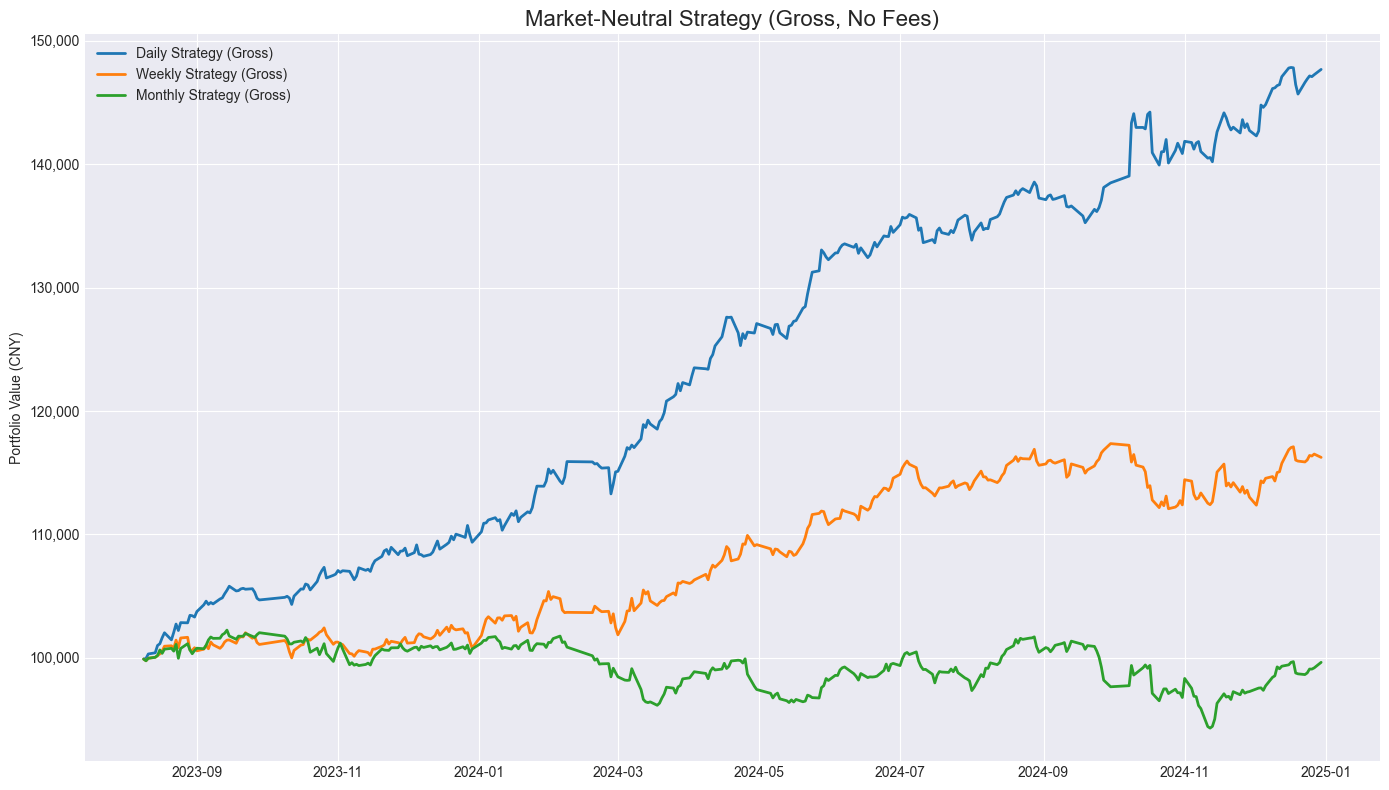

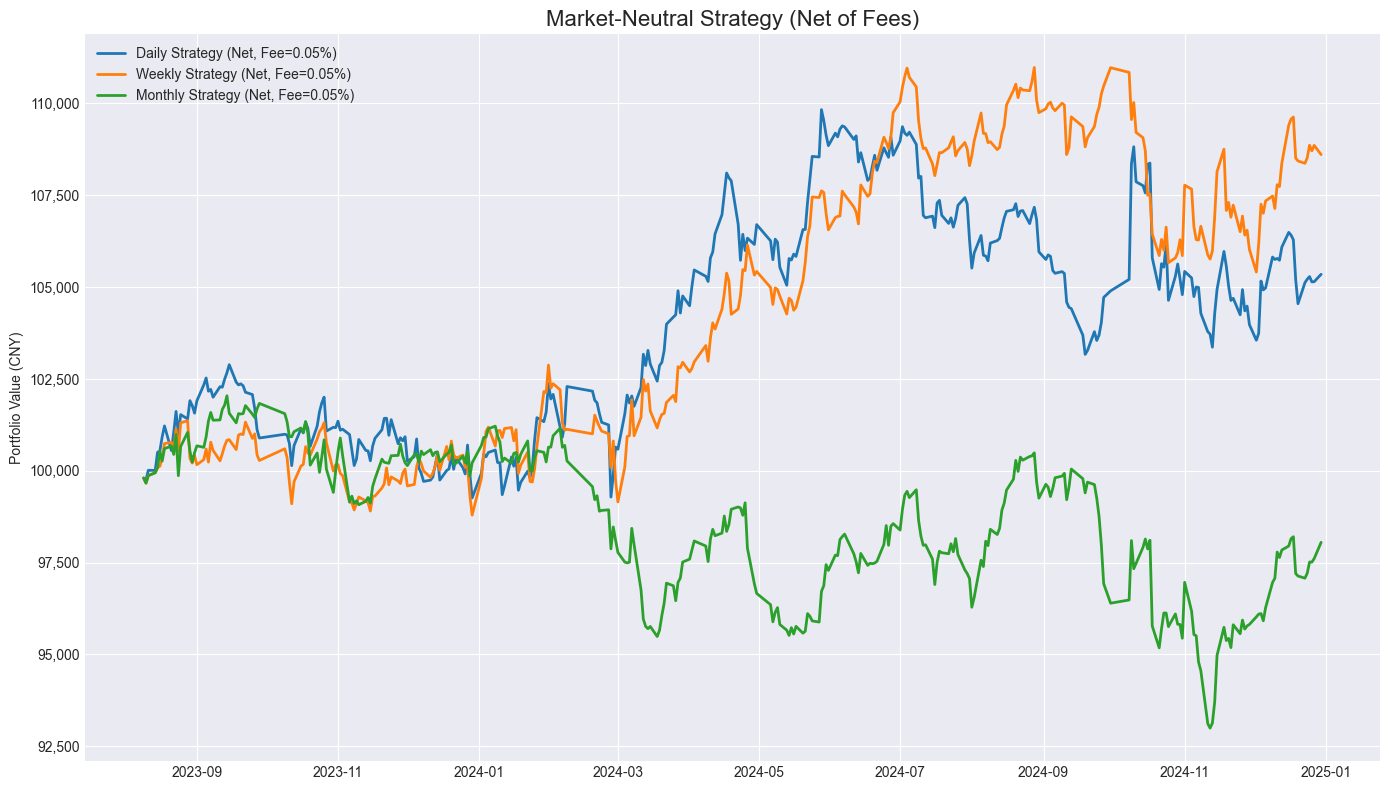


=== Gross Strategy Results (No Fees) ===


,Annual Return,Sharpe,Max Drawdown
Daily,33.73%,430.81%,-2.98%
Weekly,11.88%,161.43%,-4.50%
Monthly,-0.27%,-3.84%,-7.76%



=== Net Strategy Results (With Fees) ===


,Annual Return,Sharpe,Max Drawdown
Daily,3.96%,50.57%,-6.07%
Weekly,6.35%,86.46%,-5.02%
Monthly,-1.46%,-20.52%,-8.87%


In [ ]:
# # ==========================================================
# # Rebalancing Frequency Comparison Module (Daily / Weekly / Monthly)
# # ==========================================================
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.ticker as mtick
# from tqdm import tqdm

# def get_portfolio_percentile(default_val: int = 10) -> int:
#     """Use global PORTFOLIO_PERCENTILE if defined; otherwise fallback."""
#     try:
#         return int(PORTFOLIO_PERCENTILE)
#     except NameError:
#         return int(default_val)


# def run_backtest_with_frequency(model, panel_data, X_test, rebalance_days,
#                                 fee_rate=0.0002, portfolio_percentile=None, include_fee=True):
#     """
#     Run market-neutral backtest under a given rebalancing frequency.
#     Parameters
#     ----------
#     model : trained XGBoost model
#     panel_data : MultiIndex DataFrame (Date, Ticker) containing 'Close'
#     X_test : test-set features (same MultiIndex)
#     rebalance_days : int, rebalancing period (trading days)
#     fee_rate : float, per-trade fee per side (default 0.1%)
#     portfolio_percentile : int, top/bottom percentile for long/short
#     include_fee : bool, whether to subtract trading fees
#     """
#     if portfolio_percentile is None:
#         portfolio_percentile = get_portfolio_percentile(10)

#     if "Close" not in panel_data.columns:
#         raise ValueError("panel_data must contain a 'Close' column for price calculations.")

#     test_preds = X_test.copy()
#     test_preds["Probability_Outperform"] = model.predict_proba(X_test)[:, 1]
#     close_panel = panel_data["Close"].unstack(level="Ticker")
#     test_dates = sorted(pd.Index(test_preds.index.get_level_values("Date")).unique())
#     all_daily_returns = []

#     for i in tqdm(range(0, max(0, len(test_dates) - 1), rebalance_days), desc=f"Backtest {rebalance_days}d"):
#         start_date = test_dates[i]
#         end_idx = min(i + rebalance_days, len(test_dates) - 1)
#         end_date = test_dates[end_idx]

#         try:
#             daily_pred = test_preds.xs(start_date, level="Date")
#         except Exception:
#             continue
#         if isinstance(daily_pred, pd.Series):
#             daily_pred = daily_pred.to_frame().T
#         if daily_pred.shape[0] < 2:
#             continue

#         ranked = daily_pred.sort_values("Probability_Outperform", ascending=False)
#         n = int(len(ranked) * (portfolio_percentile / 100.0))
#         if n == 0:
#             continue
#         long_tks = pd.Index(ranked.head(n).index)
#         short_tks = pd.Index(ranked.tail(n).index)

#         try:
#             cols = long_tks.union(short_tks)
#             price_slice = close_panel.loc[start_date:end_date, cols]
#             daily_rets = price_slice.pct_change().iloc[1:]
#             long_r = daily_rets[long_tks].mean(axis=1)
#             short_r = daily_rets[short_tks].mean(axis=1)
#             period_ret = (long_r - short_r) / 2.0  # 100% long, 100% short
#             if include_fee and len(period_ret) > 0:
#                 period_ret.iloc[0] -= (fee_rate * 2.0)
#             all_daily_returns.append(period_ret.fillna(0.0))
#         except Exception:
#             continue

#     if not all_daily_returns:
#         return pd.Series([], dtype=float)

#     return pd.concat(all_daily_returns).sort_index()


# # ==========================================================
# # Run Backtests under 3 Rebalancing Frequencies
# # ==========================================================
# try:
#     _STARTING_CAPITAL = STARTING_CAPITAL
# except NameError:
#     _STARTING_CAPITAL = 100_000

# rebalance_options = {"Daily": 1, "Weekly": 5, "Monthly": 22}
# fee_rate = 0.0005  # 0.1% per side

# # --- Run gross (no fees) and net (with fees)
# gross_results, net_results = {}, {}
# for label, freq in rebalance_options.items():
#     gross = run_backtest_with_frequency(model, panel, X_test, freq, fee_rate=fee_rate, include_fee=False)
#     net = run_backtest_with_frequency(model, panel, X_test, freq, fee_rate=fee_rate, include_fee=True)
#     gross_results[label] = gross
#     net_results[label] = net

# # ==========================================================
# # Build Equity Curves
# # ==========================================================
# gross_equity = {k: (1 + v).cumprod() * _STARTING_CAPITAL for k, v in gross_results.items() if len(v) > 0}
# net_equity   = {k: (1 + v).cumprod() * _STARTING_CAPITAL for k, v in net_results.items() if len(v) > 0}

# if not gross_equity:
#     raise RuntimeError("No valid return series; please check panel / X_test indices.")

# try:
#     benchmark_equity = (1 + benchmark_returns).cumprod() * _STARTING_CAPITAL
#     first_key = next(iter(gross_equity))
#     aligned_bench = benchmark_equity.reindex(gross_equity[first_key].index).fillna(method="ffill")
# except NameError:
#     aligned_bench = None

# # ==========================================================
# # Plot 1: Gross (no fees)
# # ==========================================================
# plt.style.use("seaborn-v0_8-darkgrid")
# fig, ax = plt.subplots(figsize=(14, 8))
# for k, eq in gross_equity.items():
#     ax.plot(eq.index, eq.values, label=f"{k} Strategy (Gross)", linewidth=2)
# if aligned_bench is not None:
#     ax.plot(aligned_bench.index, aligned_bench.values, label="HS300 Index", linestyle="--", color="gray")
# ax.set_title("Market-Neutral Strategy (Gross, No Fees)", fontsize=16)
# ax.set_ylabel("Portfolio Value (CNY)")
# ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:,.0f}"))
# ax.legend()
# plt.tight_layout()
# plt.show()

# # ==========================================================
# # Plot 2: Net (with fees)
# # ==========================================================
# plt.style.use("seaborn-v0_8-darkgrid")
# fig, ax = plt.subplots(figsize=(14, 8))
# for k, eq in net_equity.items():
#     ax.plot(eq.index, eq.values, label=f"{k} Strategy (Net, Fee={fee_rate*100:.2f}%)", linewidth=2)
# if aligned_bench is not None:
#     ax.plot(aligned_bench.index, aligned_bench.values, label="HS300 Index", linestyle="--", color="gray")
# ax.set_title("Market-Neutral Strategy (Net of Fees)", fontsize=16)
# ax.set_ylabel("Portfolio Value (CNY)")
# ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:,.0f}"))
# ax.legend()
# plt.tight_layout()
# plt.show()

# # ==========================================================
# # Performance Summary Table
# # ==========================================================
# def calc_metrics(returns: pd.Series):
#     if len(returns) == 0:
#         return {"Annual Return": 0.0, "Sharpe": 0.0, "Max Drawdown": 0.0}
#     ann_ret = (1 + returns).prod() ** (252 / len(returns)) - 1
#     vol = returns.std() * np.sqrt(252)
#     sharpe = ann_ret / vol if vol != 0 else 0
#     equity = (1 + returns).cumprod()
#     dd = (equity / equity.cummax() - 1).min()
#     return {"Annual Return": ann_ret, "Sharpe": sharpe, "Max Drawdown": dd}

# gross_table = pd.DataFrame({k: calc_metrics(v) for k, v in gross_results.items()}).T
# net_table   = pd.DataFrame({k: calc_metrics(v) for k, v in net_results.items()}).T

# if aligned_bench is not None:
#     bench_ann = (aligned_bench.pct_change().fillna(0) + 1).prod() ** (252 / len(aligned_bench)) - 1
#     gross_table["Benchmark Ann. Return"] = bench_ann
#     net_table["Benchmark Ann. Return"] = bench_ann

# print("\n=== Gross Strategy Results (No Fees) ===")
# display(gross_table.style.format("{:.2%}"))
# print("\n=== Net Strategy Results (With Fees) ===")
# display(net_table.style.format("{:.2%}"))


## Long-Only Strategy: Rebalance Comparison (1, 5, 22)Build long-only portfolios from the XGBoost probabilities, compare gross vs net (with turnover-based fees) for different rebalance periods, and plot alongside the HS300 benchmark.

In [ ]:
import numpy as npimport pandas as pdimport matplotlib.pyplot as pltimport matplotlib.ticker as mtickdef long_only_returns_by_rebalance(pred_df, close_panel, rebalance_days=1, top_pct=10):    test_dates = sorted(pred_df.index.get_level_values('Date').unique())    all_rets = []    baskets = {}    for i in range(0, max(0, len(test_dates)-1), int(rebalance_days)):        d0 = test_dates[i]        d1 = test_dates[min(i+int(rebalance_days), len(test_dates)-1)]        row = pred_df.loc[d0]        if isinstance(row, pd.Series):            row = row.to_frame().T        if row.shape[0] < 1:            continue        n = len(row)        k = max(1, int(n * float(top_pct) / 100.0))        longs = row.sort_values('prob', ascending=False).head(k).index.tolist()        baskets[d0] = set(longs)        try:            price_slice = close_panel.loc[d0:d1, longs]            stock_rets = price_slice.pct_change().iloc[1:]            if stock_rets.empty:                continue            long_ret = stock_rets[longs].mean(axis=1)            long_ret.name = 'LongOnly'            all_rets.append(long_ret)        except Exception:            continue    rets = (pd.concat(all_rets).sort_index() if all_rets else pd.Series([], dtype=float))    return rets, basketsdef compute_long_only_fees(baskets_by_date, ret_index, fee_per_side_total):    fee = pd.Series(0.0, index=ret_index)    prev = set()    for d0 in sorted(baskets_by_date.keys()):        curr = baskets_by_date[d0]        k_curr = max(1, len(curr))        entries = len(curr - prev)        exits = len(prev - curr)        gross_turnover = (entries + exits) / k_curr        dec = gross_turnover * float(fee_per_side_total)        later = ret_index[ret_index >= d0]        if len(later) > 0:            fee.loc[later[0]] += dec        prev = curr    return feetry:    top_pct = int(PORTFOLIO_PERCENTILE)except Exception:    top_pct = 10try:    start_cap = float(STARTING_CAPITAL)except Exception:    start_cap = 100000.0try:    fee_ps = float(FEE_PER_SIDE_TOTAL)except Exception:    fee_ps = 0.0007rebalance_set = [1, 5, 22]gross_series = {}net_series = {}for r in rebalance_set:    rets, baskets = long_only_returns_by_rebalance(pred, close_panel, rebalance_days=r, top_pct=top_pct)    fees = compute_long_only_fees(baskets, rets.index, fee_ps)    gross_series[r] = rets    net_series[r] = rets - fees.reindex(rets.index).fillna(0.0)# Build equity curvesgross_eq = {r: (1 + s).cumprod() * start_cap for r, s in gross_series.items() if len(s) > 0}net_eq   = {r: (1 + s).cumprod() * start_cap for r, s in net_series.items() if len(s) > 0}# Benchmark equity aligned to earliest series starttry:    min_start = min([ser.index.min() for ser in list(gross_series.values()) + list(net_series.values()) if len(ser) > 0])    bench_eq = (1 + bm_daily_ret).cumprod() * start_cap    bench_eq = bench_eq.loc[bench_eq.index >= min_start]except Exception:    bench_eq = Noneplt.style.use('seaborn-v0_8-darkgrid')fig, ax = plt.subplots(figsize=(14, 8))color_map = {1: 'tab:blue', 5: 'tab:orange', 22: 'tab:green'}for r, eq in gross_eq.items():    ax.plot(eq.index, eq.values, linestyle='--', color=color_map.get(r, None), label=f'Long-only Gross (reb={r})', linewidth=1.8)for r, eq in net_eq.items():    ax.plot(eq.index, eq.values, linestyle='-', color=color_map.get(r, None), label=f'Long-only Net (reb={r})', linewidth=2.2)if bench_eq is not None:    ax.plot(bench_eq.index, bench_eq.values, linestyle=':', color='gray', label='HS300 Benchmark')ax.set_title('Long-only Strategy: Gross vs Net by Rebalance Period', fontsize=15)ax.set_ylabel('Portfolio Value (CNY)')ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}'))ax.legend(ncol=2)plt.tight_layout()plt.show()